<a href="https://colab.research.google.com/github/gankidisaicharan/Brain-Tumor-Detection/blob/main/BrainTumorDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pathlib
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import pandas as pd
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')


In [ ]:
from os import listdir
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import imutils
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle #shuffling the data improves the model

In [ ]:
image_dir="/content/drive/MyDrive/PROJECTS/Brain tumor detection/brain_tumor_dataset"

In [ ]:
augmentedimages='/content/drive/MyDrive/PROJECTS/Brain tumor detection/brain_tumor_dataset/augmentedimages'

In [ ]:
if not os.path.exists(augmentedimages):
    os.makedirs(augmentedimages)
    os.makedirs('/content/drive/MyDrive/PROJECTS/Brain tumor detection/brain_tumor_dataset/augmentedimages/Tumor detected')
    os.makedirs('/content/drive/MyDrive/PROJECTS/Brain tumor detection/brain_tumor_dataset/augmentedimages/No Tumor detected')

In [ ]:
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.1,
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest'
                                 )

    for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        image = image.reshape((1,)+image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i=0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
                i += 1
                if i > n_generated_samples:
                    break


augmented_data_path ='/content/drive/MyDrive/PROJECTS/Brain tumor detection/brain_tumor_dataset/augmentedimages'
augment_data(file_dir=image_dir+'/'+'Tumor detected',n_generated_samples=6, save_to_dir=augmented_data_path+'/'+'Tumor detected')
augment_data(file_dir=image_dir+'/'+'No Tumor detected', n_generated_samples=9, save_to_dir=augmented_data_path+'/'+'No Tumor detected')

In [ ]:
import cv2
import imutils
import matplotlib.pyplot as plt

def crop_brain_contour(image, plot=False):
    if image is None:
        print("Invalid image")
        return None

    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    if len(cnts) == 0:
        print("No contours found in the image")
        return None

    c = max(cnts, key=cv2.contourArea)
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()

    return new_image


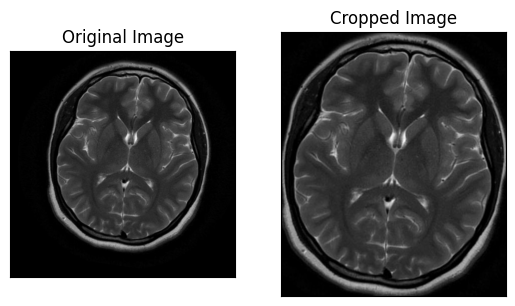

In [ ]:
ex_img = cv2.imread('/content/drive/MyDrive/PROJECTS/Brain tumor detection/brain_tumor_dataset/augmentedimages/No Tumor detected/aug_1 no._0_1849.jpg')
ex_crop_img = crop_brain_contour(ex_img, True)

In [ ]:
# Path to the data directory
data_dir = '/content/drive/MyDrive/PROJECTS/Brain tumor detection/brain_tumor_dataset/augmentedimages'
SEED = 1   # maybe can do with random seed generator and compare results with different seed values in the future.
BATCH_SIZE = 32
IMG_SIZE = (240,240)

X_train = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    seed = SEED,
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    validation_split = 0.2,
    subset = 'training'
)

X_validation = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    seed = SEED,
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    validation_split = 0.2,
    subset = 'validation'
)

Found 2064 files belonging to 2 classes.
Using 1652 files for training.
Found 2064 files belonging to 2 classes.
Using 412 files for validation.


In [ ]:
file_path = '/content/drive/MyDrive/PROJECTS/Brain tumor detection/brain_tumor_dataset/augmentedimages'
data_dir = pathlib.Path(file_path)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['No Tumor detected' 'Tumor detected']


<Figure size 2000x2000 with 0 Axes>

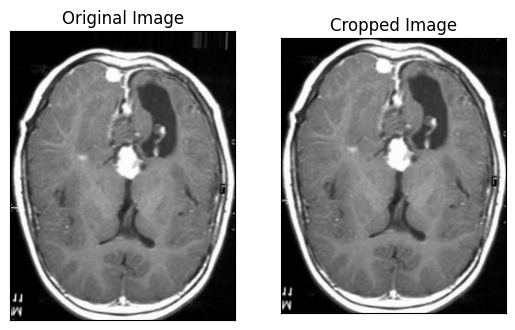

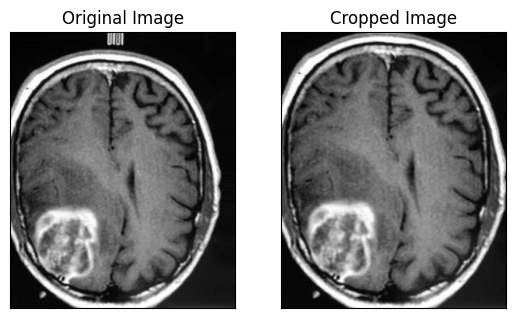

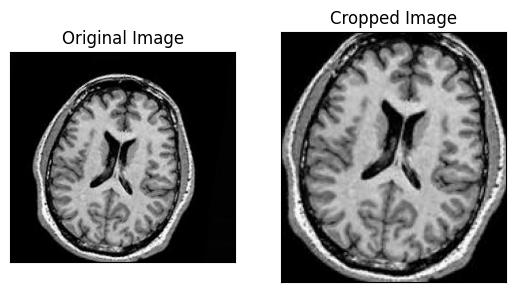

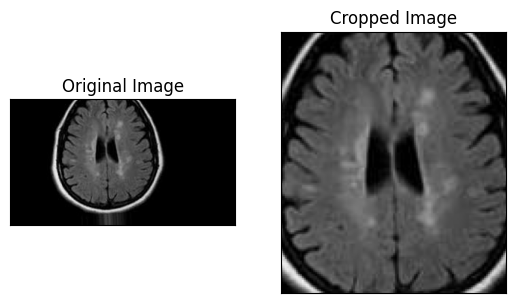

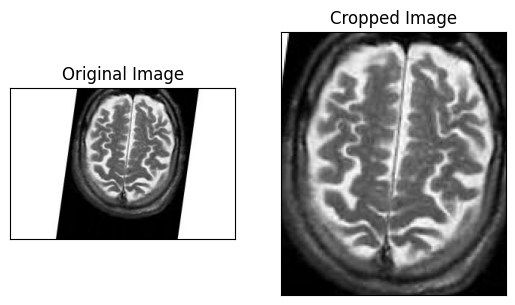

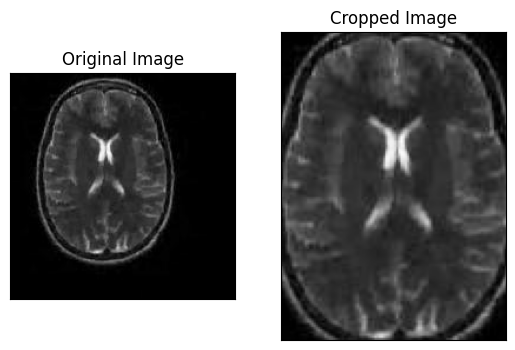

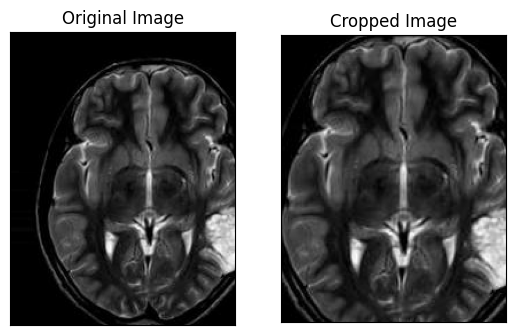

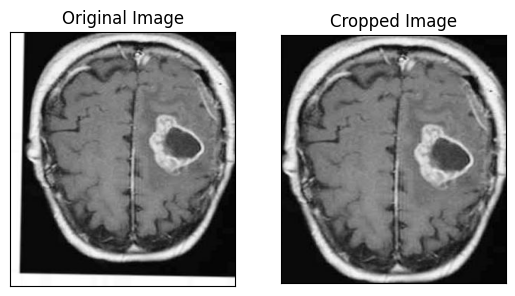

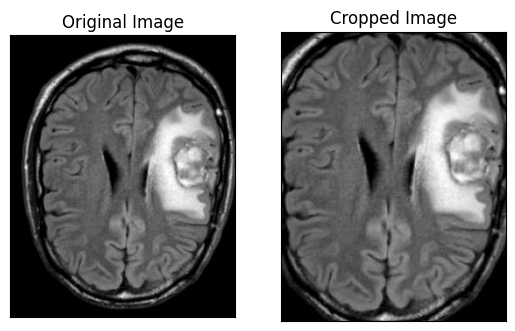

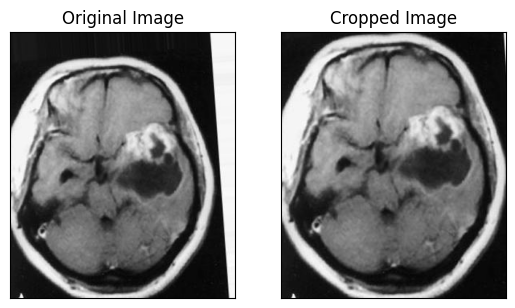

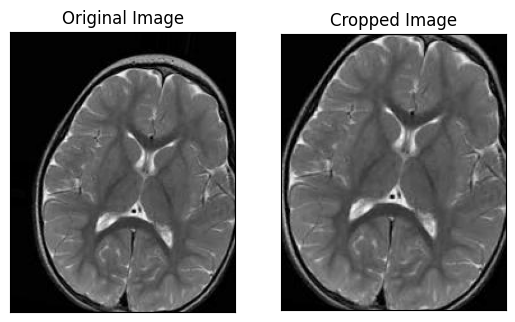

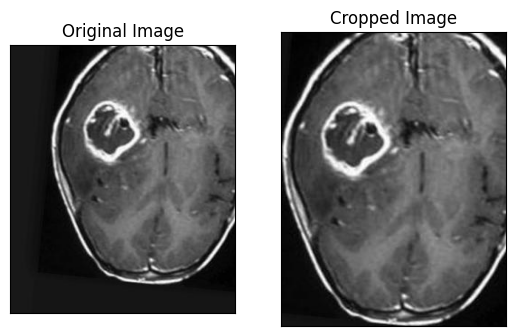

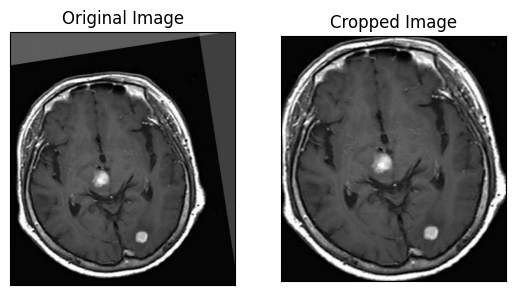

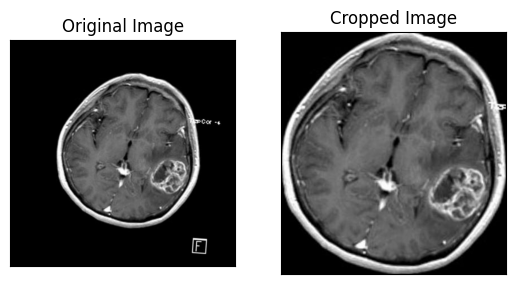

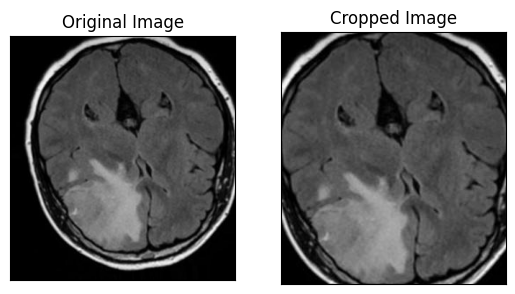

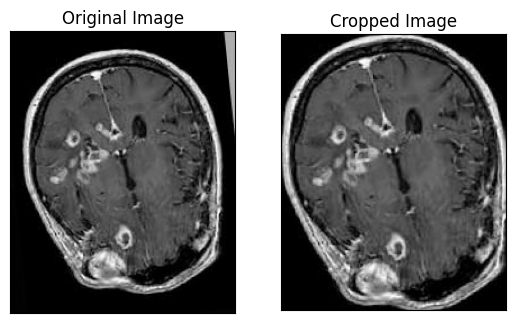

In [ ]:
plt.figure(figsize=(20, 20))
for i in range(16):
    random_class = random.randint(0, 1)
    folder_path = file_path + '/' + class_names[random_class]
    random_image_path = folder_path + '/' + (random.sample(os.listdir(folder_path), 1)[0])
    image = cv2.imread(random_image_path)
    ex_crop_img = crop_brain_contour(image, True)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
IMG_SIZE=(240,240)
INPUT_SHAPE = IMG_SIZE + (3,)
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Rescaling(scale=1./255, input_shape=INPUT_SHAPE))
model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(0.20))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(2, activation = 'softmax'))

In [ ]:
# Set the hyperparameters
learning_rate = 0.0001
num_epochs = 30
early_stop_patience = 10

In [ ]:
optimizer = Adam(learning_rate=learning_rate)

In [ ]:
# Set up callbacks for the training process
log_dir = 'logs/'
tb_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
model_filepath='/content/drive/MyDrive/PROJECTS/Brain tumor detection/model/model-{epoch:02d}-{val_accuracy:.4f}.hdf5'
checkpoint = ModelCheckpoint(model_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
early_stop_callback = EarlyStopping(monitor='val_loss', patience=early_stop_patience)

In [ ]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 2)                

In [ ]:
batch_size=32
epochs=50

In [ ]:
history = model.fit(X_train,epochs=num_epochs, validation_data=X_validation,verbose=1,callbacks=[tb_callback,checkpoint, reduce_lr_callback, early_stop_callback])

Epoch 1/30
52/52 [==============================] - ETA: 0s - loss: 0.6345 - accuracy: 0.6265
Epoch 1: val_accuracy improved from -inf to 0.70388, saving model to /content/drive/MyDrive/PROJECTS/Brain tumor detection/model/model-01-0.7039.hdf5
52/52 [==============================] - 105s 2s/step - loss: 0.6345 - accuracy: 0.6265 - val_loss: 0.5968 - val_accuracy: 0.7039 - lr: 1.0000e-04
Epoch 2/30
51/52 [============================>.] - ETA: 0s - loss: 0.5563 - accuracy: 0.7188
Epoch 2: val_accuracy improved from 0.70388 to 0.76699, saving model to /content/drive/MyDrive/PROJECTS/Brain tumor detection/model/model-02-0.7670.hdf5
52/52 [==============================] - 4s 73ms/step - loss: 0.5555 - accuracy: 0.7191 - val_loss: 0.5218 - val_accuracy: 0.7670 - lr: 1.0000e-04
Epoch 3/30
51/52 [============================>.] - ETA: 0s - loss: 0.5199 - accuracy: 0.7506
Epoch 3: val_accuracy improved from 0.76699 to 0.79126, saving model to /content/drive/MyDrive/PROJECTS/Brain tumor detec

In [ ]:
df = pd.DataFrame(history.history)
ax = df.plot(figsize=(10,5), lw=3, grid='on')
ax.set_title('History per Epoch', fontsize=18, fontweight='bold')
ax.set_xlabel('Epochs', fontsize=15, fontweight='bold')
ax.plot()

ValueError: ignored

In [ ]:
# Load the saved model
model = load_model('/content/drive/MyDrive/PROJECTS/Brain tumor detection/model/model-17-0.9005.hdf5')

In [ ]:
model_evaluate = model.evaluate(X_validation)
print("Accuracy: %", "{:.2f}".format(model_evaluate[1]*100))
print("Loss: %", "{:.2f}".format(model_evaluate[0]*100))

13/13 [==============================] - 28s 250ms/step - loss: 0.3195 - accuracy: 0.9005
Accuracy: % 90.05
Loss: % 31.95


1/1 [==============================] - 0s 18ms/step


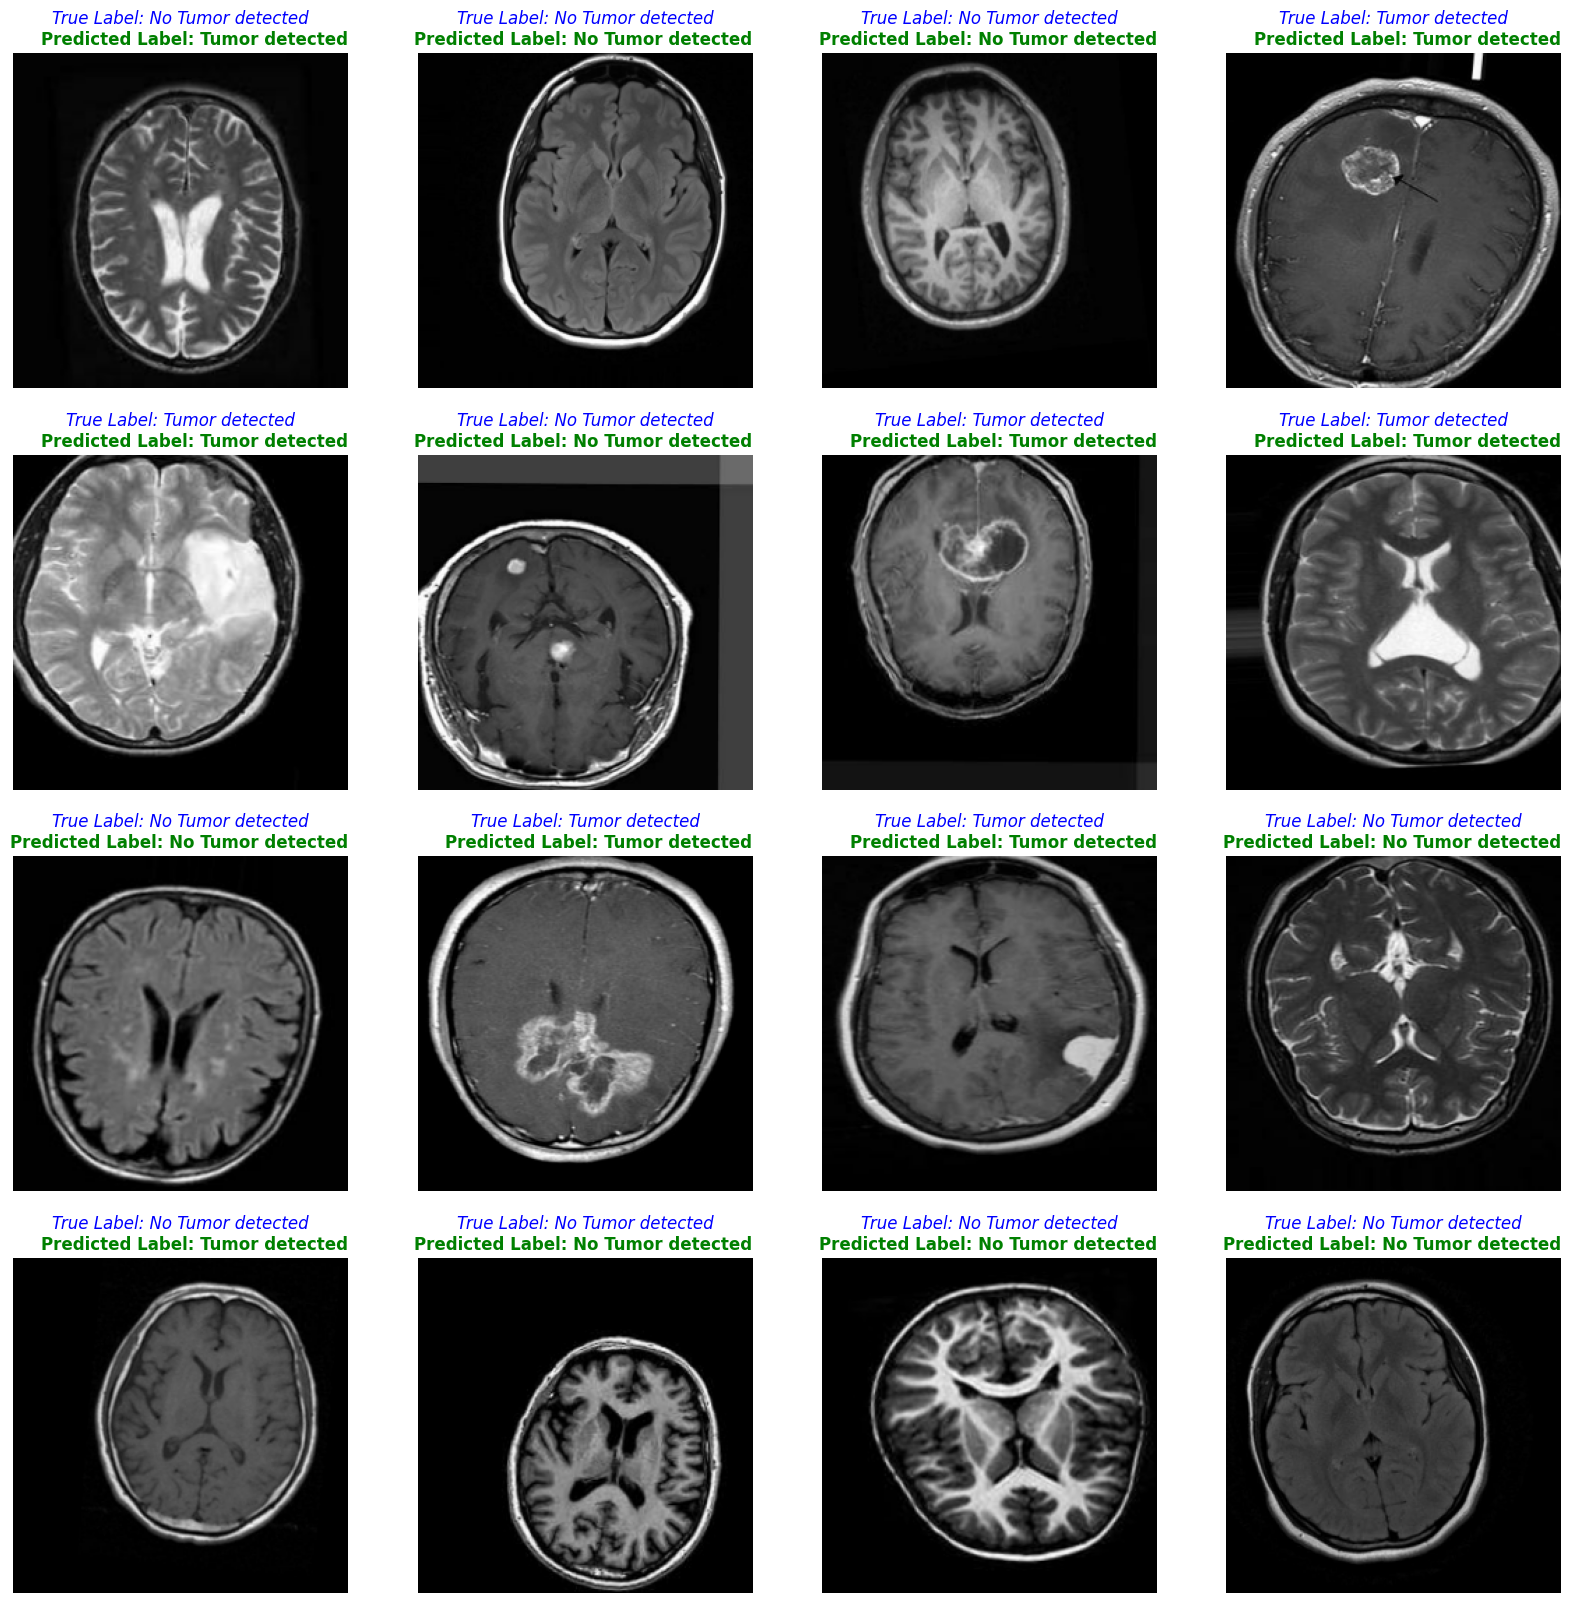

In [ ]:
plt.figure(figsize=(20, 20))
for image, label in X_validation.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        img = image[i].numpy().astype("uint8")
        img = tf.expand_dims(img, axis=0)
        predicted_class = np.argmax(model.predict(img))
        plt.axis('off')
        plt.title("True Label: " + class_names[label[i]]+'\n', fontsize=12, style='italic', color='blue', loc='center')
        plt.title("Predicted Label: " + class_names[predicted_class], fontsize=12, fontweight='bold', color='green', loc='right')
        plt.imshow(image[i].numpy().astype("uint8"))

In [ ]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 69.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.5/140.5 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 67.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 k

In [ ]:
import gradio as gr
import cv2
import imutils
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

def predict_brain_tumor(image):
    cropped_image = crop_brain_contour(image)
    if cropped_image is None:
        return "No contours found in the image"
    else:
        # Load the saved model
        model = load_model('/content/drive/MyDrive/PROJECTS/Brain tumor detection/model/model-17-0.9005.hdf5')

        img = cropped_image.astype("uint8")
        img = cv2.resize(img, (240, 240))  # Add the resize step
        img = tf.expand_dims(img, axis=0)
        predicted_class = np.argmax(model.predict(img))

        if predicted_class == 0:
            return "No Tumor detected"
        else:
            return "Tumor detected"



inputs = gr.inputs.Image(label="Input Image")
outputs = gr.outputs.Textbox(label="Prediction")

title = "Brain Tumor Detection"
description = "Upload an image and the model will predict whether it contains a brain tumor or not"

gr.Interface(fn=predict_brain_tumor, inputs=inputs, outputs=outputs, title=title, description=description).launch(debug=True,share=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://396028522aa2a5603e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


1/1 [==============================] - 0s 102ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://396028522aa2a5603e.gradio.live


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam


In [ ]:
# Input shape of images
img_rows, img_cols, img_channels = 240, 240, 3

In [ ]:
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channels))


58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
for layer in vgg.layers:
    layer.trainable = False


In [ ]:
# Create a new sequential model
model = Sequential()

# Add the VGG16 model as a layer
model.add(vgg)

# Add some new layers on top of the VGG16 model
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))


In [ ]:
model.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Path to the data directory
data_dir = '/content/drive/MyDrive/PROJECTS/Brain tumor detection/brain_tumor_dataset/augmentedimages'
SEED = 1   # maybe can do with random seed generator and compare results with different seed values in the future.
BATCH_SIZE = 32
IMG_SIZE = (240,240)

X_train = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    seed = SEED,
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    validation_split = 0.2,
    subset = 'training'
)

X_validation = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    seed = SEED,
    image_size = IMG_SIZE,
    batch_size = BATCH_SIZE,
    validation_split = 0.2,
    subset = 'validation'
)

Found 2064 files belonging to 2 classes.
Using 1652 files for training.
Found 2064 files belonging to 2 classes.
Using 412 files for validation.


In [ ]:
batch_size=32
epochs=50

In [ ]:
history = model.fit(X_train,epochs=num_epochs, validation_data=X_validation,verbose=1,callbacks=[tb_callback,checkpoint, reduce_lr_callback, early_stop_callback])

Epoch 1/30
52/52 [==============================] - ETA: 0s - loss: 4.7641 - accuracy: 0.7058
Epoch 1: val_accuracy improved from -inf to 0.91262, saving model to /content/drive/MyDrive/PROJECTS/Brain tumor detection/model/model-01-0.9126.hdf5
52/52 [==============================] - 36s 450ms/step - loss: 4.7641 - accuracy: 0.7058 - val_loss: 0.7360 - val_accuracy: 0.9126 - lr: 1.0000e-04
Epoch 2/30
52/52 [==============================] - ETA: 0s - loss: 1.7227 - accuracy: 0.8456
Epoch 2: val_accuracy improved from 0.91262 to 0.93932, saving model to /content/drive/MyDrive/PROJECTS/Brain tumor detection/model/model-02-0.9393.hdf5
52/52 [==============================] - 15s 285ms/step - loss: 1.7227 - accuracy: 0.8456 - val_loss: 0.4124 - val_accuracy: 0.9393 - lr: 1.0000e-04
Epoch 3/30
52/52 [==============================] - ETA: 0s - loss: 1.0252 - accuracy: 0.8862
Epoch 3: val_accuracy improved from 0.93932 to 0.95146, saving model to /content/drive/MyDrive/PROJECTS/Brain tumor d

In [ ]:
model_evaluate = model.evaluate(X_validation)
print("Accuracy: %", "{:.2f}".format(model_evaluate[1]*100))
print("Loss: %", "{:.2f}".format(model_evaluate[0]*100))

13/13 [==============================] - 2s 154ms/step - loss: 0.2316 - accuracy: 0.9782
Accuracy: % 97.82
Loss: % 23.16


[]

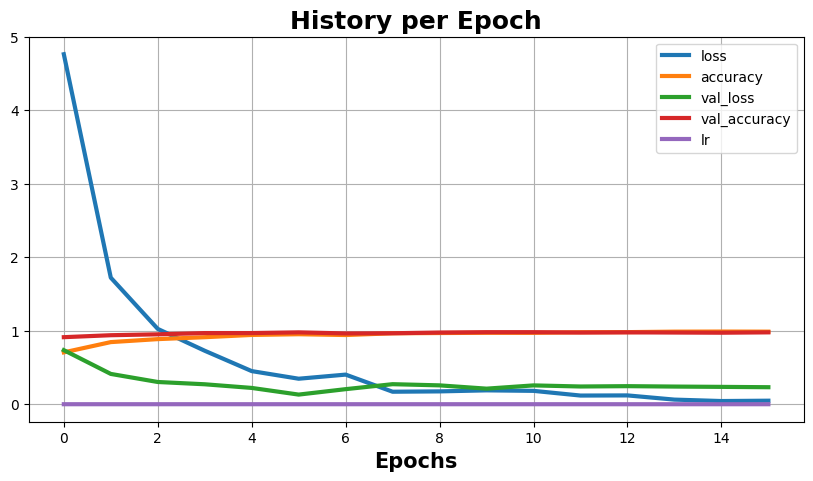

In [ ]:
df = pd.DataFrame(history.history)
ax = df.plot(figsize=(10,5), lw=3, grid='on')
ax.set_title('History per Epoch', fontsize=18, fontweight='bold')
ax.set_xlabel('Epochs', fontsize=15, fontweight='bold')
ax.plot()

In [ ]:
# Load the saved model
model_vgg = load_model('/content/drive/MyDrive/PROJECTS/Brain tumor detection/model/model-10-0.9806.hdf5')

1/1 [==============================] - 0s 19ms/step


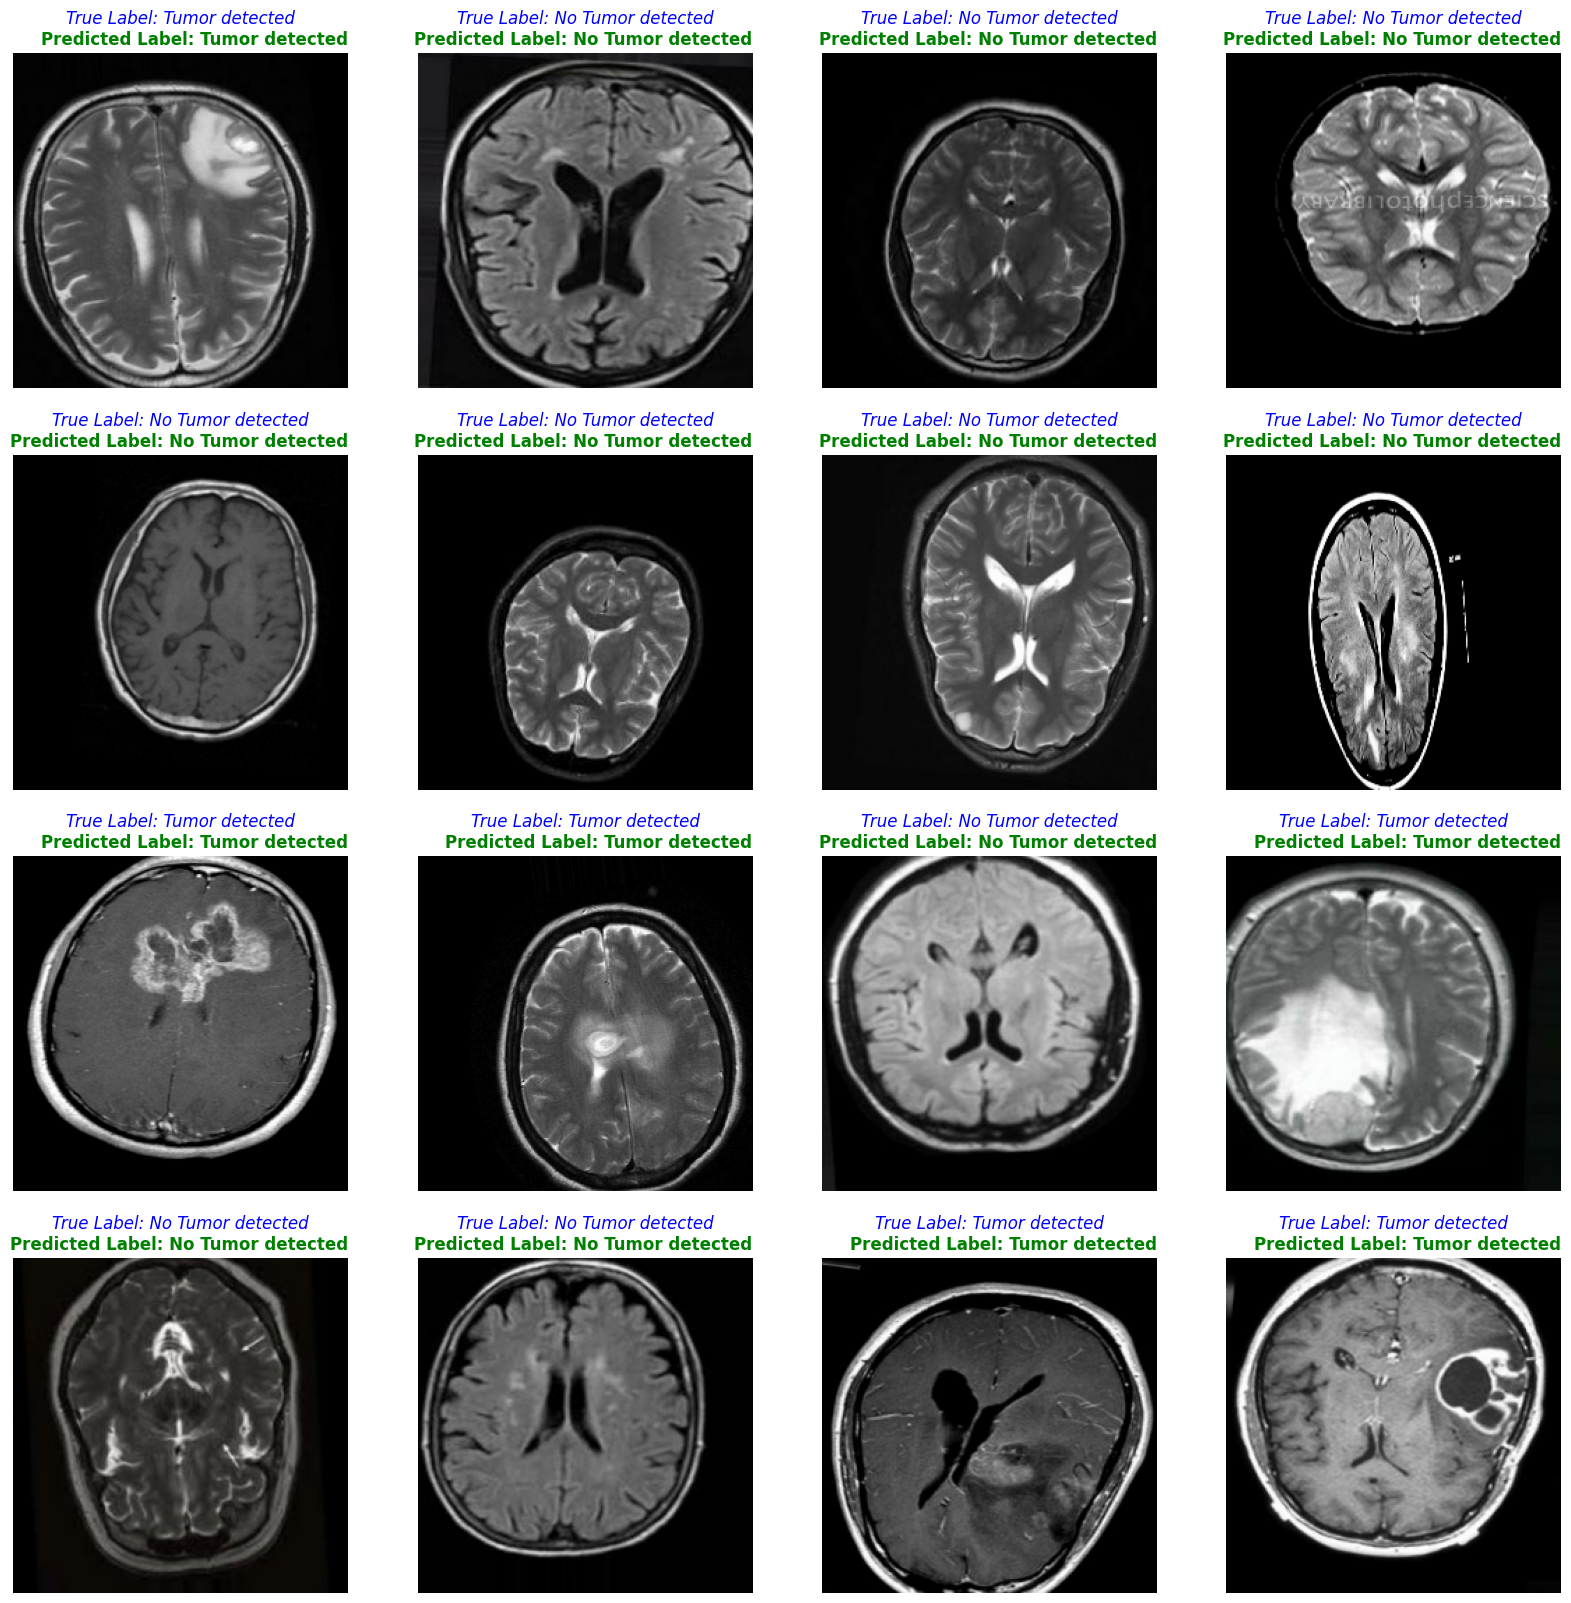

In [ ]:
plt.figure(figsize=(20, 20))
for image, label in X_validation.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        img = image[i].numpy().astype("uint8")
        img = tf.expand_dims(img, axis=0)
        predicted_class = np.argmax(model_vgg.predict(img))
        plt.axis('off')
        plt.title("True Label: " + class_names[label[i]]+'\n', fontsize=12, style='italic', color='blue', loc='center')
        plt.title("Predicted Label: " + class_names[predicted_class], fontsize=12, fontweight='bold', color='green', loc='right')
        plt.imshow(image[i].numpy().astype("uint8"))

In [ ]:
import gradio as gr
import cv2
import imutils
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

def predict_brain_tumor(image):
    cropped_image = crop_brain_contour(image)
    if cropped_image is None:
        return "No contours found in the image"
    else:
        # Load the saved model
        model = load_model('/content/drive/MyDrive/PROJECTS/Brain tumor detection/model/model-17-0.9005.hdf5')

        img = cropped_image.astype("uint8")
        img = cv2.resize(img, (240, 240))  # Add the resize step
        img = tf.expand_dims(img, axis=0)
        predicted_class = np.argmax(model.predict(img))

        if predicted_class == 0:
            return "No Tumor detected"
        else:
            return "Tumor detected"



inputs = gr.inputs.Image(label="Input Image")
outputs = gr.outputs.Textbox(label="Prediction")

title = "Brain Tumor Detection"
description = "Upload an image and the model will predict whether it contains a brain tumor or not"

gr.Interface(fn=predict_brain_tumor, inputs=inputs, outputs=outputs, title=title, description=description).launch(debug=True,share=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://16887b6099fec40b62.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


1/1 [==============================] - 0s 21ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://16887b6099fec40b62.gradio.live


In [ ]:
'/content/drive/MyDrive/PROJECTS/Brain tumor detection/brain_tumor_dataset/augmentedimages/yes/aug_Y100_0_1733.jpg'

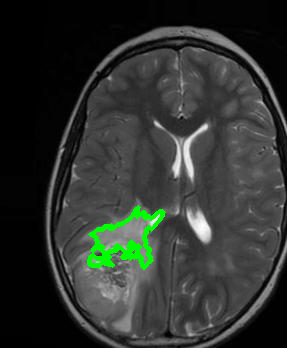

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread('/content/drive/MyDrive/PROJECTS/Brain tumor detection/brain_tumor_dataset/augmentedimages/yes/aug_Y100_0_1733.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
max_area = 0
max_contour = None
for contour in contours:
    area = cv2.contourArea(contour)
    if area > max_area and area < 10000:
        max_area = area
        max_contour = contour
cv2.drawContours(img, [max_contour], -1, (0, 255, 0), 3)
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
import cv2
import gradio as gr
import numpy as np

def highlight_tumor(image):
    # Convert PIL image to NumPy array
    img = np.array(image)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply a threshold to create a binary mask
    ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

    # Find contours in the binary mask
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour with the largest area
    max_area = 0
    max_contour = None
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > max_area and area < 600: # ignore contours larger than 10000 pixels
            max_area = area
            max_contour = contour

    # Draw the largest contour on the original image
    cv2.drawContours(img, [max_contour], -1, (0, 255, 0), 3)

    # Convert the image to RGB format and return it
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

# Define the input and output interfaces for the Gradio app
inputs = gr.inputs.Image(type="pil", label="Input Image")
outputs = gr.outputs.Image(type="numpy", label="Output Image")

# Create the Gradio app
gradio_app = gr.Interface(fn=highlight_tumor, inputs=inputs, outputs=outputs, title="Tumor Highlighter")

# Run the Gradio app
gradio_app.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://5f7fb86eaa7283d168.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


In [ ]:
import gradio as gr
import cv2
import imutils
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from PIL import Image
import zipfile
import io

def predict_brain_tumor(zip_file):
    # Load the saved model
    model = load_model('/content/drive/MyDrive/PROJECTS/Brain tumor detection/model/model-10-0.8047.hdf5')

    predictions = []
    with zipfile.ZipFile(io.BytesIO(zip_file.read())) as zf:
        for image_name in zf.namelist():
            with zf.open(image_name) as image:
                pil_image = Image.open(image)
                np_image = np.array(pil_image)
                cropped_image = crop_brain_contour(np_image)

                if cropped_image is None:
                    predictions.append(f"{image_name}: No contours found in the image")
                else:
                    img = cropped_image.astype("uint8")
                    img = cv2.resize(img, (240, 240))
                    img = tf.expand_dims(img, axis=0)
                    predicted_class = np.argmax(model.predict(img))

                    if predicted_class == 0:
                        predictions.append(f"{image_name}: No Tumor detected")
                    else:
                        predictions.append(f"{image_name}: Tumor detected")

    return "\n".join(predictions)

inputs = gr.inputs.File(label="Input Zip File")
outputs = gr.outputs.Textbox(label="Predictions")

title = "Brain Tumor Detection"
description = "Upload a zip file containing one or multiple images and the model will predict whether they contain a brain tumor or not"

gr.Interface(fn=predict_brain_tumor, inputs=inputs, outputs=outputs, title=title, description=description).launch(debug=True, share=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://4a919e3ed7c7533482.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/gradio/routes.py", line 394, in run_predict
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.9/dist-packages/gradio/blocks.py", line 1075, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.9/dist-packages/gradio/blocks.py", line 884, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/usr/local/lib/python3.9/dist-packages/anyio/to_thread.py", line 31, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.9/dist-packages/anyio/_backends/_asyncio.py", line 937, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.9/dist-packages/anyio/_backends/_asyncio.py", line 867, in run
    result = context.run(func, *args)
  File "<ipython-input-130-03b8f82b865c>", line 17, in predict_brain_tumor
    with zipfile.ZipFile(io.BytesIO(zip_file.read())) as 